In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Value():

    def __init__(self, data, _children = (), _op = "", label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
        self._backward = lambda: None
        self.label  = label
    
    def __repr__(self) -> str:
        return (f"Value({self.data})")
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other  = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __radd__(self, other):
        return self + other
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1 )/(math.exp(2*x) + 1 )
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t*t) * out.grad
        out._backward = _backward

        return(out)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward

        return(out) 

    def backward(self):
        
        topo = []
        Visited = set()
        def build_topo(v):
            if v not in Visited:
                Visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

In [3]:
from graphviz import Digraph

def trace(root):

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):

    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad, ), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return(dot)


In [4]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.881373, label = 'b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1 ; x1w1.label='x1w1'
x2w2 = x2 * w2 ; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = 'tanh'
o.backward()

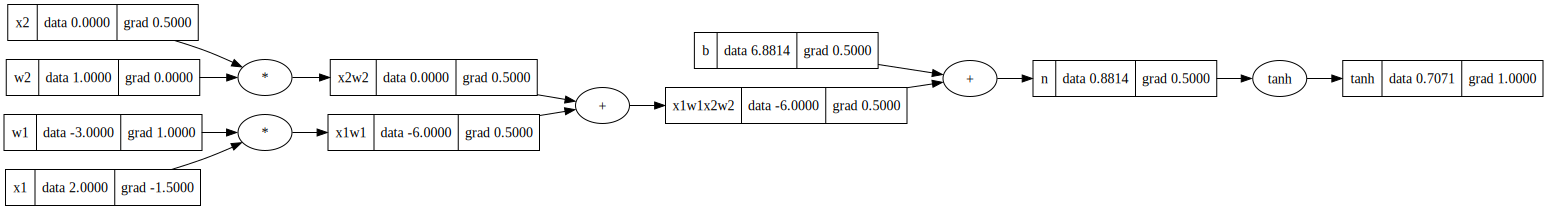

In [5]:
draw_dot(o)

In [6]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return(outs[0] if len(outs) == 1 else outs)
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [7]:
x = [3.0, 4.0, -1.0]
n = MLP(3, [4, 4, 1])
#draw_dot(n(x))

In [8]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [9]:
for k in range(100):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yi - yi_pred)**2 for yi, yi_pred in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update parameters
    for p in n.parameters():
        p.data -= 0.05 * p.grad
    
    print(k, loss.data, )

0 4.555267868916832
1 2.985979546056683
2 2.323151140764505
3 1.7400395232325707
4 1.2112459295137108
5 0.8792269536365879
6 0.7025175458131379
7 0.6019091736248567
8 0.5272953472812845
9 0.46902198078638235
10 0.42217842797915467
11 0.38364822196140935
12 0.35136528056604655
13 0.3239064856489265
14 0.30025793648802274
15 0.2796759741043881
16 0.26160145734242307
17 0.24560499750717787
18 0.23135082495518286
19 0.2185722471586297
20 0.20705454380556798
21 0.19662276957253466
22 0.1871328788035322
23 0.17846515065476995
24 0.17051924029033388
25 0.16321040071347645
26 0.1564665613676276
27 0.15022604316198507
28 0.14443575261966626
29 0.13904974113245533
30 0.13402804553030429
31 0.12933574760417516
32 0.12494220563149325
33 0.12082042217935565
34 0.11694652073588023
35 0.11329930988742962
36 0.10985991840263241
37 0.10661148811282006
38 0.10353891418373448
39 0.10062862446423732
40 0.09786839122614922
41 0.09524716988661679
42 0.09275496031299169
43 0.09038268711166768
44 0.0881220959

In [10]:
ypred

[Value(0.9295408223013685),
 Value(-0.8905577669881671),
 Value(-0.8978208487363929),
 Value(0.907902466172457)]